In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms,datasets
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
import time
from torch import autograd
plt.style.use('default')

In [ ]:
transform =  transforms.ToTensor()


trainset = datasets.MNIST(root='./MNIST', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True) # training data
print('Size of training set = ',len(train_loader.dataset))
testset = datasets.MNIST(root='./MNIST', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False) # testing data
print('Size of test set = ',len(test_loader.dataset))                                         

Size of training set =  60000
Size of test set =  10000


In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [ ]:
def to_np(x):
    return x.data.cpu().numpy()

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)    


In [ ]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Encoder
class Q_net(nn.Module):  
    def __init__(self,X_dim,N,z_dim):
        super(Q_net, self).__init__()
        self.lin1 = nn.Linear(X_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3gauss = nn.Linear(N, z_dim)
    def forward(self, x):
        x = F.dropout(self.lin1(x))
        x = F.relu(x)
        x = F.dropout(self.lin2(x))
        x = F.relu(x)
        xgauss = self.lin3gauss(x)
        return xgauss


In [ ]:
# Decoder
class P_net(nn.Module):  
    def __init__(self,X_dim,N,z_dim):
        super(P_net, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, X_dim)
    def forward(self, x):
        x = F.dropout(self.lin1(x))
        x = F.relu(x)
        x = F.dropout(self.lin2(x))
        x = self.lin3(x)
        return torch.sigmoid(x)

In [ ]:
# Gaussian discriminator
class D_net_gauss(nn.Module):  
    def __init__(self,N,z_dim):
        super(D_net_gauss, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, 2)
    def forward(self, x):
        x = F.dropout(self.lin1(x))
        x = F.relu(x)
        x = F.dropout(self.lin2(x))
        x = F.relu(x)
        return torch.sigmoid(self.lin3(x)) 

In [ ]:
EPS = 1e-15 # value of epsilon
z_red_dims = 2
encoder = Q_net(784,1000,z_red_dims).to(device)
decoder = P_net(784,1000,z_red_dims).to(device)
Disc = D_net_gauss(500,z_red_dims).to(device)

In [ ]:
# Set learning rates
gen_lr = 0.0001
reg_lr = 0.00005

In [ ]:
#encode/decode optimizers
optim_decoder = torch.optim.Adam(decoder.parameters(), lr=gen_lr)
optim_encoder = torch.optim.Adam(encoder.parameters(), lr=gen_lr)
#regularizing optimizers
optim_encoder_reg = torch.optim.Adam(encoder.parameters(), lr=reg_lr)
optim_D1 = torch.optim.Adam(Disc.parameters(), lr=reg_lr)

In [ ]:
# MSE LOSS

ae_criterion1 = nn.MSELoss()
num_epochs = 10
train_loss1 = []
disc_loss1=[]
train_acc1 = []
outputs = []

In [ ]:
def training(encoder, decoder, Disc, dataloader, optim_encoder, optim_decoder, optim_D, ae_criterion, train):
    total_rec_loss = 0
    total_disc_loss = 0
    total_gen_loss = 0
    if train:
        encoder.train()
        decoder.train()
        Disc.train()
    else:
        encoder.eval()
        decoder.eval()
        Disc.eval()

    for i, (data, labels) in enumerate(dataloader):
        """ Reconstruction loss """
        for p in Disc.parameters():
            p.requires_grad = False

        real_data_v = autograd.Variable(data).to(device)
        real_data_v = real_data_v.view(-1, 784).to(device)
        #print(real_data_v.size())
        encoding = encoder(real_data_v).to(device)
        fake = decoder(encoding).to(device)
        ae_loss = ae_criterion(fake, real_data_v)
        total_rec_loss += ae_loss.item()
        if train:
            optim_encoder.zero_grad()
            optim_decoder.zero_grad()
            ae_loss.backward()
            optim_encoder.step()
            optim_decoder.step()

        """ Discriminator loss """
        encoder.eval()
        z_real_gauss = autograd.Variable(torch.randn(data.size()[0], 2) * 5.).to(device)
        D_real_gauss = Disc(z_real_gauss)

        z_fake_gauss = encoder(real_data_v)
        D_fake_gauss = Disc(z_fake_gauss)

        D_loss = -torch.mean(torch.log(D_real_gauss + EPS) + torch.log(1 - D_fake_gauss + EPS))
        total_disc_loss += D_loss.item()

        if train:
            optim_D.zero_grad()
            D_loss.backward()
            optim_D.step()

        """ Generator loss """
        if train:
            encoder.train()
        else:
            encoder.eval()
        z_fake_gauss = encoder(real_data_v)
        D_fake_gauss = Disc(z_fake_gauss)

        G_loss = -torch.mean(torch.log(D_fake_gauss + EPS))
        total_gen_loss += G_loss.item()

        if train:
            optim_encoder_reg.zero_grad()
            G_loss.backward()
            optim_encoder_reg.step()


        if i % 500 == 0:
            print ('\n Step [%d], recon_loss: %.4f, discriminator_loss :%.4f , generator_loss:%.4f'
                    %(i, ae_loss.item(), D_loss.item(), G_loss.item()))
            outputs.append((epoch, data, fake))

    M = len(dataloader.dataset)
    return total_rec_loss /M  , total_disc_loss /M , total_gen_loss /M


In [ ]:
# MSE LOSS

for epoch in range(num_epochs):
    l1,l2 ,l3 = training(encoder, decoder, Disc, train_loader, optim_encoder, optim_decoder, optim_D1, ae_criterion1, True)
    print('\n epoch:{} ---- training loss:{}'.format((epoch+1), l1))
    train_loss1.append(l1)
    disc_loss1.append(l2)



 Step [0], recon_loss: 0.2337, discriminator_loss :1.5549 , generator_loss:0.7440

 Step [500], recon_loss: 0.0543, discriminator_loss :1.7329 , generator_loss:0.7503

 epoch:1 ---- training loss:0.0009577070053045948

 Step [0], recon_loss: 0.0521, discriminator_loss :1.7275 , generator_loss:0.7539

 Step [500], recon_loss: 0.0518, discriminator_loss :1.7089 , generator_loss:0.7565

 epoch:2 ---- training loss:0.0008074263135592143

 Step [0], recon_loss: 0.0535, discriminator_loss :1.6651 , generator_loss:0.7427

 Step [500], recon_loss: 0.0516, discriminator_loss :1.6390 , generator_loss:0.7516

 epoch:3 ---- training loss:0.0007837238640834887

 Step [0], recon_loss: 0.0482, discriminator_loss :1.7062 , generator_loss:0.7469

 Step [500], recon_loss: 0.0469, discriminator_loss :1.7145 , generator_loss:0.7428

 epoch:4 ---- training loss:0.0007709074682866533

 Step [0], recon_loss: 0.0458, discriminator_loss :1.6745 , generator_loss:0.7659

 Step [500], recon_loss: 0.0486, discrim

Text(0, 0.5, 'Training')

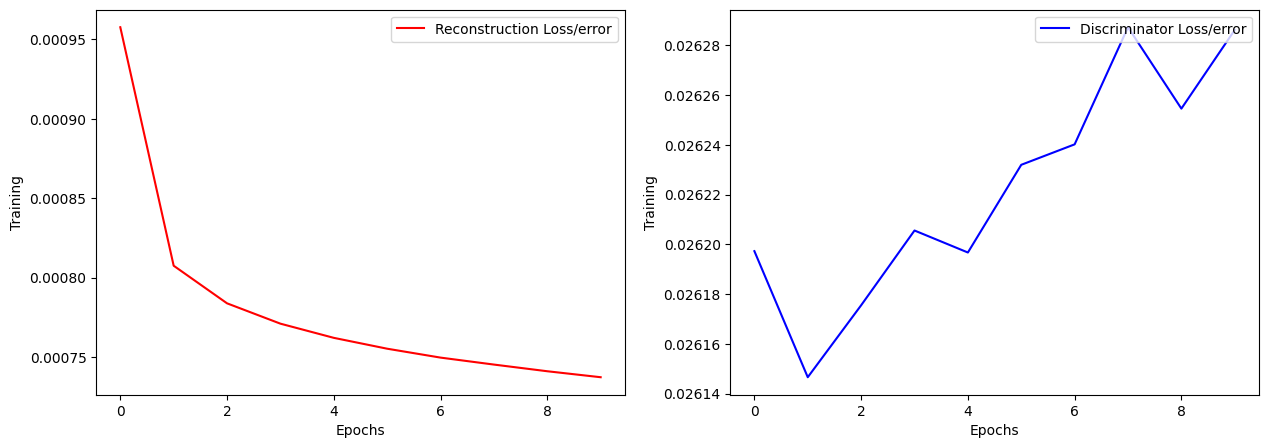

In [ ]:
# MSE LOSS

fig = plt.figure(figsize=[15,5]) 
plt.subplot(121)
plt.plot(range(num_epochs),train_loss1,'r-',label='Reconstruction Loss/error') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')
plt.subplot(122)
plt.plot(range(num_epochs),disc_loss1,'b-',label='Discriminator Loss/error') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')

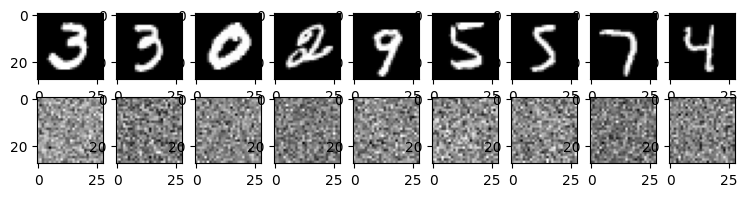

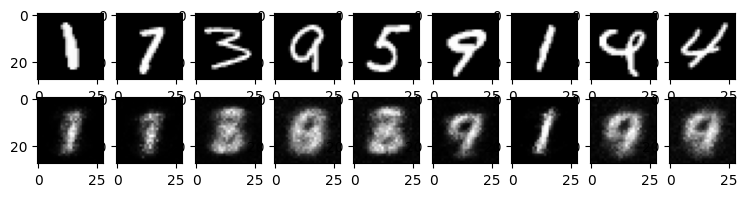

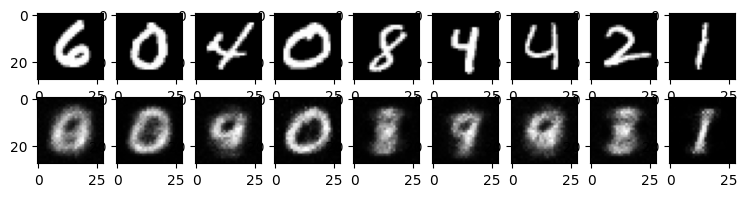

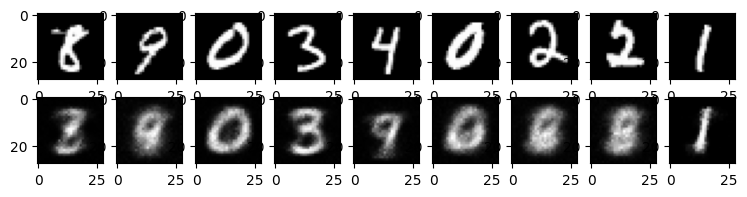

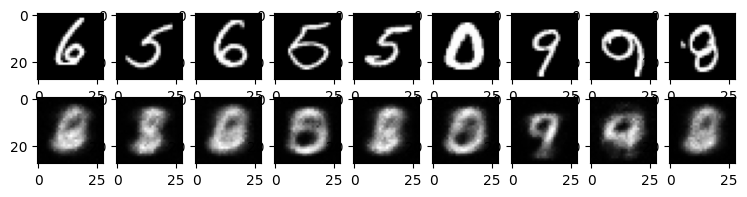

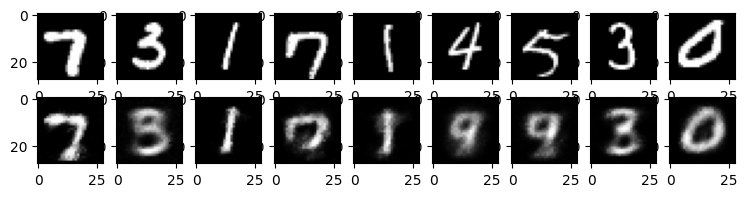

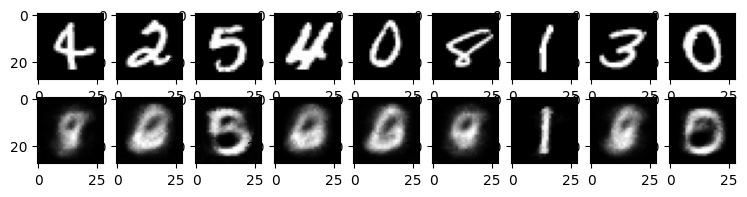

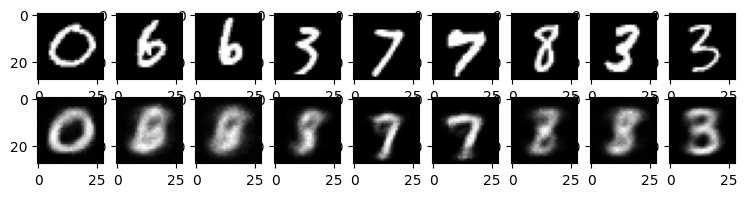

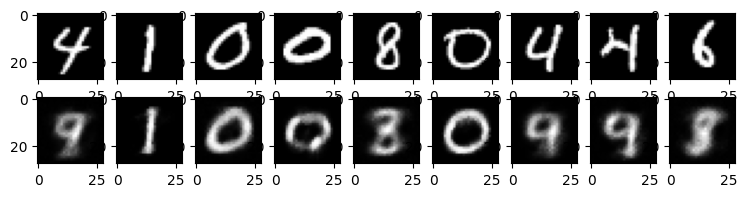

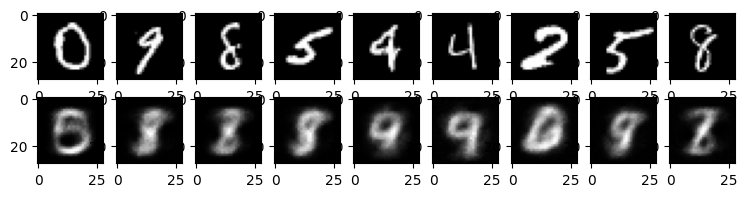

In [ ]:
# MSE LOSS

for k in range(0,num_epochs):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

In [ ]:
# BCE LOSS

ae_criterion2 = nn.BCELoss()
train_loss2 = []
disc_loss2=[]
train_acc2 = []
outputs = []

In [ ]:
# BCE LOSS

for epoch in range(num_epochs):
    l1,l2 ,l3 = training(encoder, decoder, Disc, train_loader, optim_encoder, optim_decoder, optim_D1, ae_criterion2, True)
    print('\n epoch:{} ---- training loss:{}'.format((epoch+1), l1))
    train_loss2.append(l1)
    disc_loss2.append(l2)



 Step [0], recon_loss: 0.1894, discriminator_loss :1.6331 , generator_loss:0.7419

 Step [500], recon_loss: 0.1880, discriminator_loss :1.6316 , generator_loss:0.7335

 epoch:1 ---- training loss:0.003181390896687905

 Step [0], recon_loss: 0.2056, discriminator_loss :1.6423 , generator_loss:0.7367

 Step [500], recon_loss: 0.2035, discriminator_loss :1.7645 , generator_loss:0.7505

 epoch:2 ---- training loss:0.003158875715235869

 Step [0], recon_loss: 0.2131, discriminator_loss :1.5807 , generator_loss:0.7432

 Step [500], recon_loss: 0.2021, discriminator_loss :1.6689 , generator_loss:0.7317

 epoch:3 ---- training loss:0.003147219603260358

 Step [0], recon_loss: 0.2082, discriminator_loss :1.6212 , generator_loss:0.7349

 Step [500], recon_loss: 0.1874, discriminator_loss :1.6506 , generator_loss:0.7462

 epoch:4 ---- training loss:0.003138920743763447

 Step [0], recon_loss: 0.1967, discriminator_loss :1.7574 , generator_loss:0.7400

 Step [500], recon_loss: 0.2035, discriminat

Text(0, 0.5, 'Training')

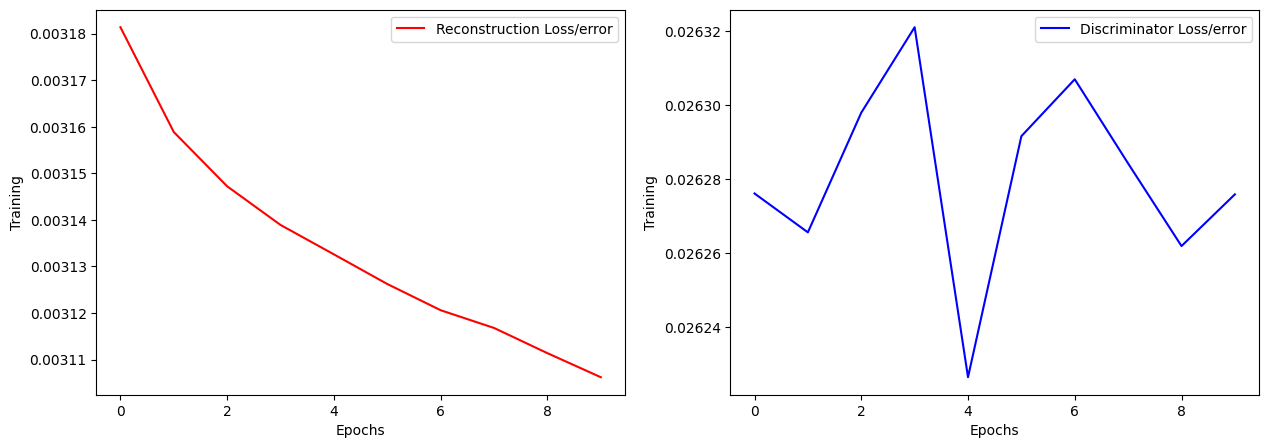

In [ ]:
# BCE LOSS

fig = plt.figure(figsize=[15,5]) 
plt.subplot(121)
plt.plot(range(num_epochs),train_loss2,'r-',label='Reconstruction Loss/error') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')
plt.subplot(122)
plt.plot(range(num_epochs),disc_loss2,'b-',label='Discriminator Loss/error') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')

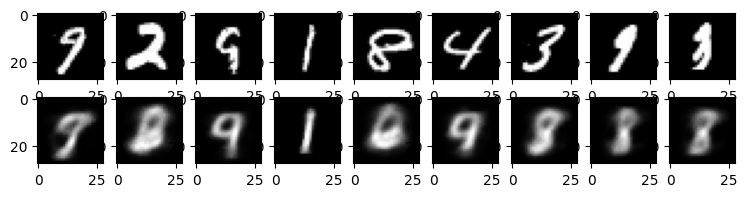

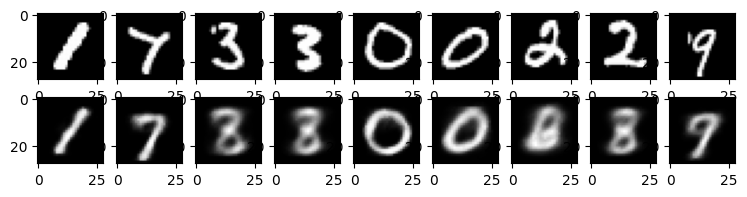

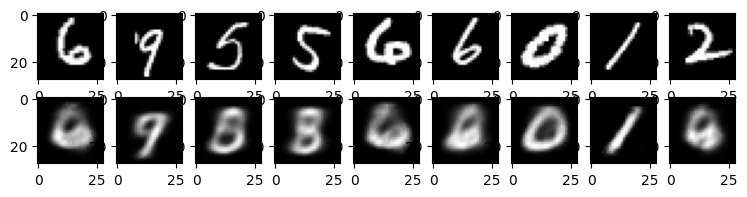

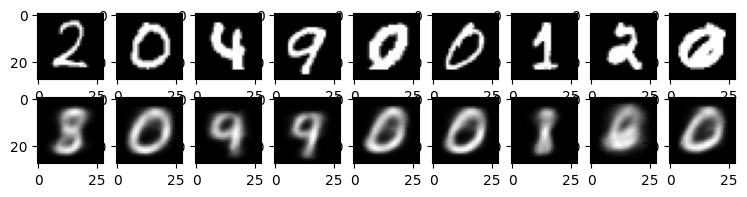

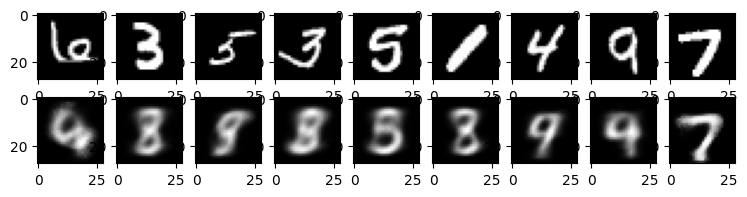

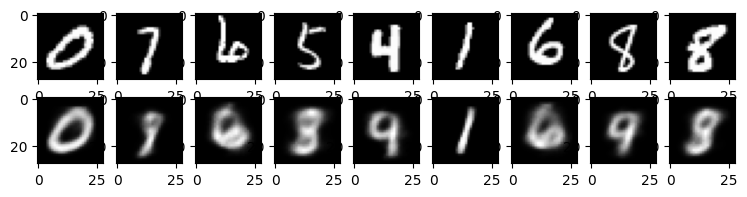

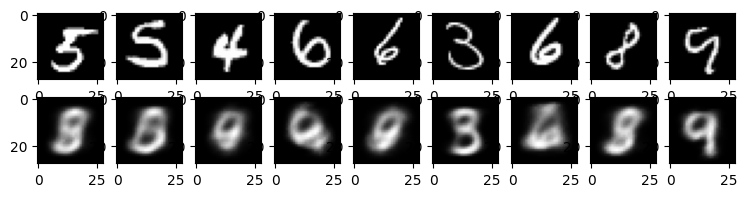

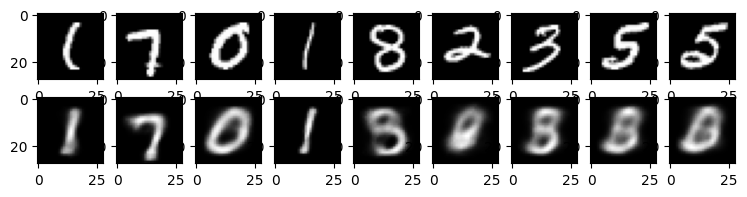

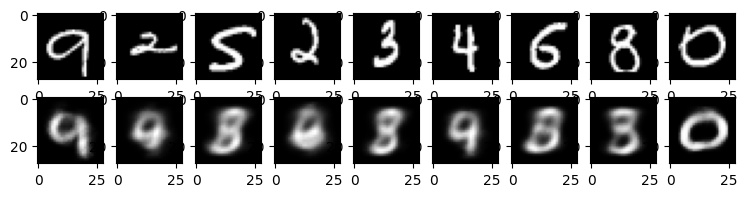

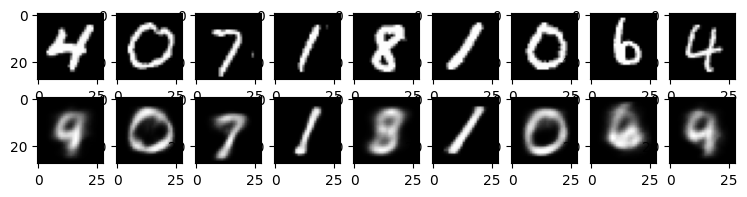

In [ ]:
# BCE LOSS

for k in range(0,num_epochs):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

In [ ]:
!pip install pytorch_msssim
from pytorch_msssim import ssim

In [ ]:
def ssimLoss(y_pred, y_true):
  y_pred = y_pred.detach().cpu().numpy()
  y_true = y_true.detach().cpu().numpy()
  return 1-tf.reduce_mean(tf.image.ssim(y_true,y_pred,1.0))

In [ ]:
# SSIM LOSS

ae_criterion3 = ssim
train_loss3 = []
disc_loss3=[]
train_acc3 = []
outputs = []

In [ ]:
# SSIM LOSS

for epoch in range(num_epochs):
    l1,l2 ,l3 = training(encoder, decoder, Disc, train_loader, optim_encoder, optim_decoder, optim_D1, ae_criterion3,True)
    print('\n epoch:{} ---- training loss:{}'.format((epoch+1), l1))
    train_loss2.append(l1)
    disc_loss2.append(l2)

ValueError: ignored

In [ ]:
'''
Q2 - The Reconstruction loss graph has a monotonically decreasing nature with the number of epochs, while the discriminator error 
seems to oscillate within a small range of numbers. 

Q3 - Constructing the autoencoder:
1. Building the ENCODER part : The encoder encodes the high dimension input into a lower-dimensional latent
 representation also referred to as the bottleneck layer.
2. Building the DECODER part : The decoder will decompress the latent representation to recreate the input data.
3. The output layer uses a sigmoid activation function as it flattens the output to be in the range[0,1] .
4. We are using different loss functions as defined in the question, they represent different aspects of similarity/differences
between the original and reconstructed images.
5. The discriminator will be able to tell the difference between a real and a fake image that has been created.

Q5 - Between MSE and BCE loss, MSE seems better as it gives a more apparent drop in Loss value corresopnding to the no. of epochs
making it more interpretable for the model's results.
'''